In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipas
import matplotlib.pyplot as plt
import numpy as np
import time
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import dask
import pandas as pd
from dask import dataframe as dd
import pickle

In [ ]:
cluster = SLURMCluster(
queue='batch',
walltime='10-23:00:00',
cores=1,
constraint='mpi_ib',
memory='10000MiB', #1 GiB = 1,024 MiB
processes=1)

cluster.scale(7)
client = Client(cluster)
print(client)

In [ ]:
client

In [3]:
def main():
    output = np.empty((len(phioarr),len(reqarr), nclusters),dtype=object)
    for phi in range(len(phioarr)):
        for r in range(len(reqarr)):
            for n in range(nclusters):
                #output[phi,r,n] = dask.delayed(ipas.collect_clusters_alldask)(phioarr[phi], reqarr[r], ncrystals, rand_orient)
                ipas.collect_clusters_alldask(phioarr[phi], reqarr[r], ncrystals, rand_orient)
#     delayeds = client.compute(delayeds)
#     output = client.gather(delayeds)
    return output

In [4]:
def compute():
    agg_as = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    agg_bs = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    agg_cs = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    phi2Ds = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    cplxs = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    dds = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    
    gather = client.compute([*output.tolist()])  #only parallelizing agg r bins
    gather = client.gather(gather)

    gather = np.array(gather)
    print(np.shape(gather))
    agg_as = gather[:,:,0]
    agg_bs = gather[:,:,1]
    print(agg_bs)
    agg_cs = gather[:,:,2]
    phi2Ds = gather[:,:,3]
    cplxs = gather[:,:,4] 
    dds = gather[:,:,5]
    print('DONE!')
    return agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds


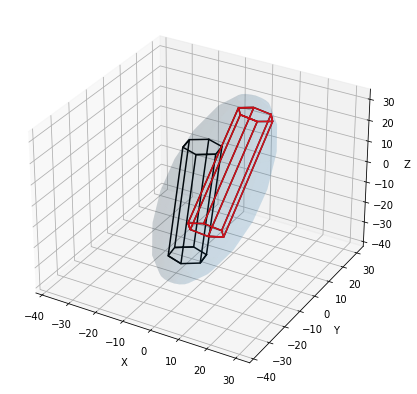

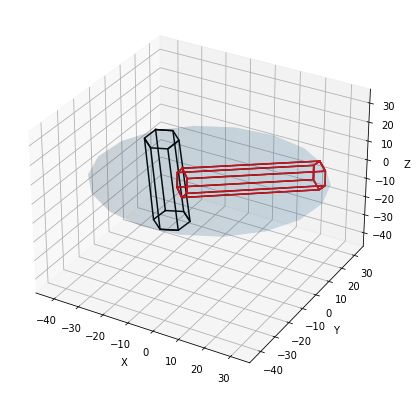

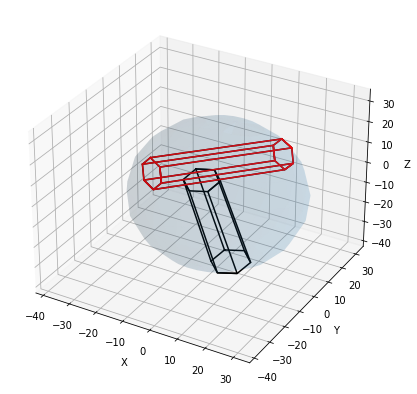

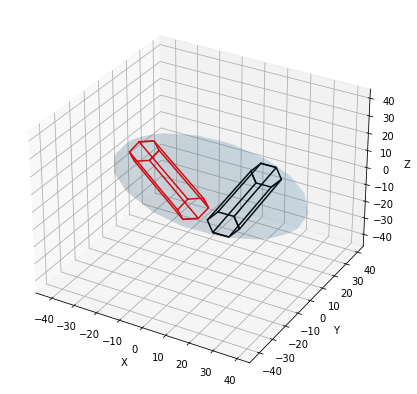

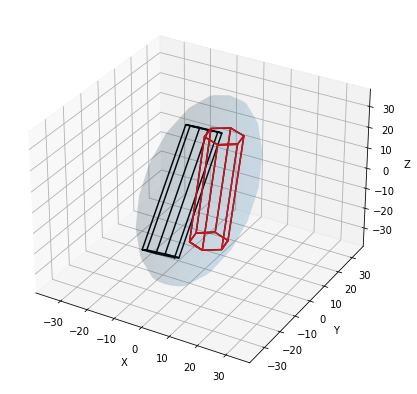

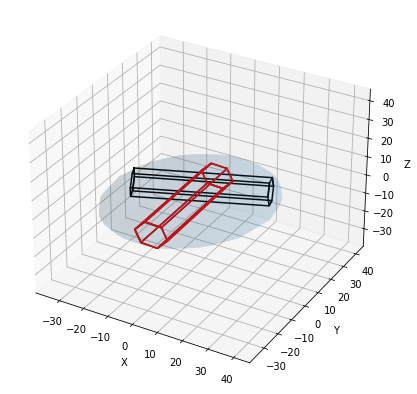

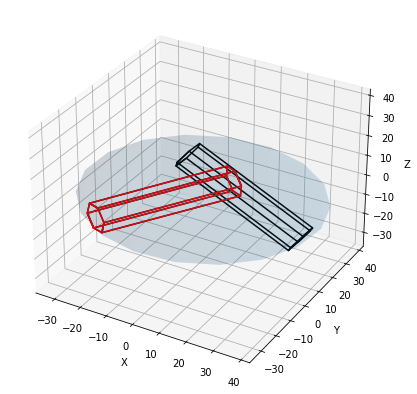

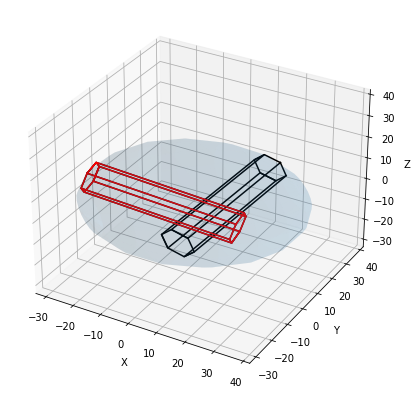

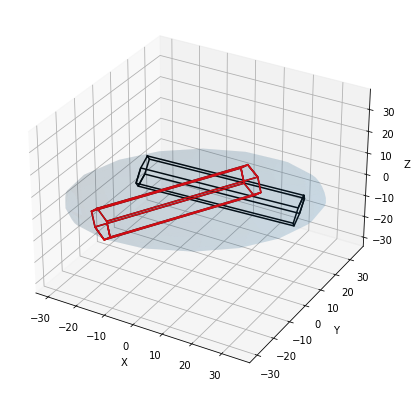

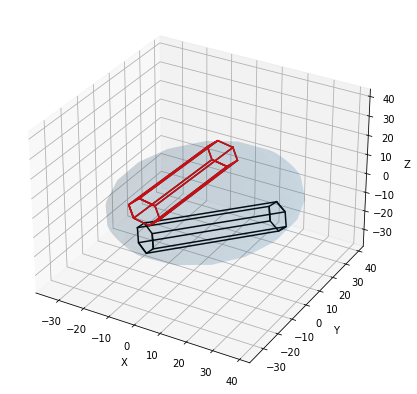

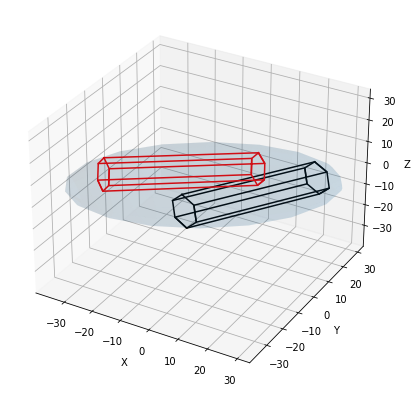

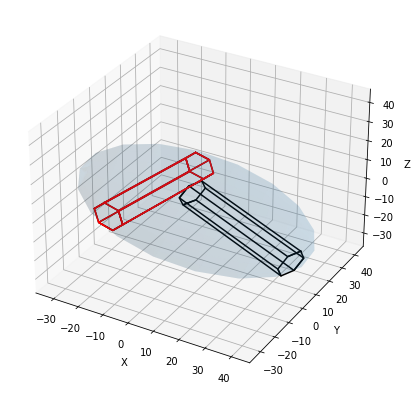

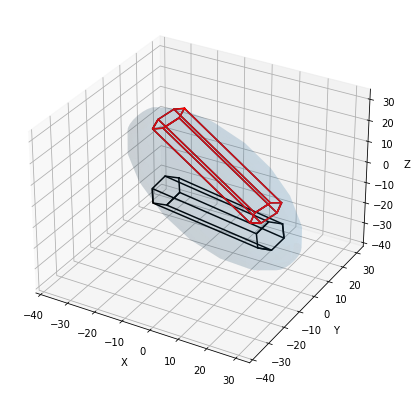

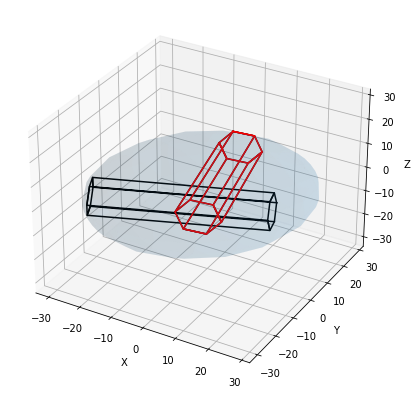

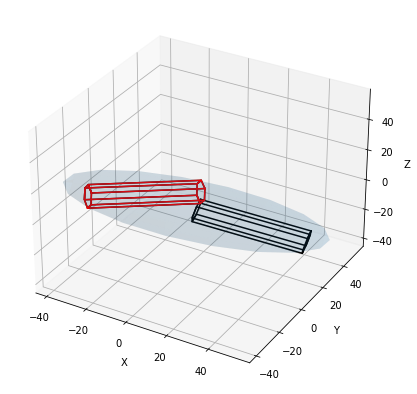

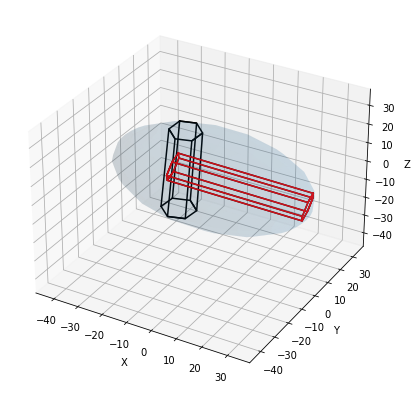

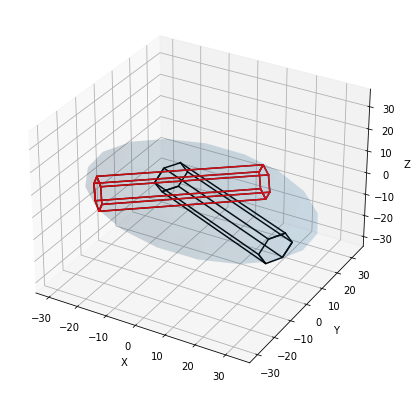

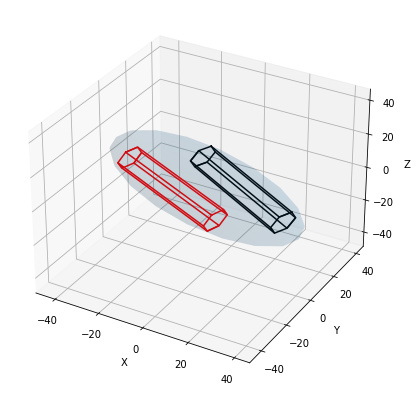

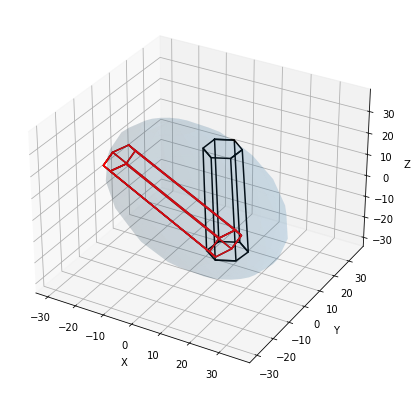

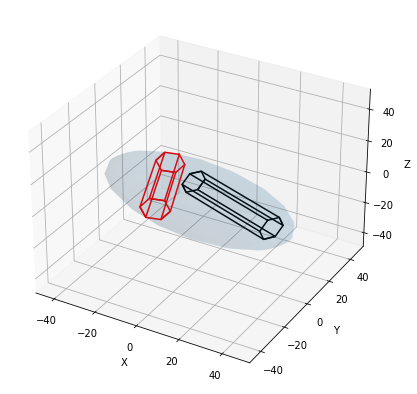

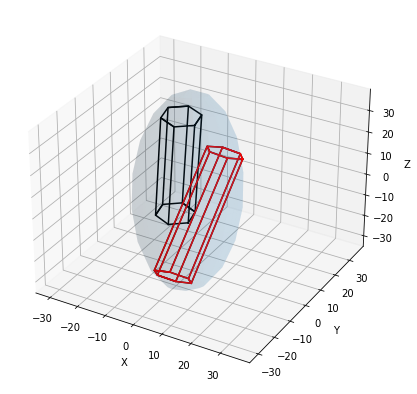

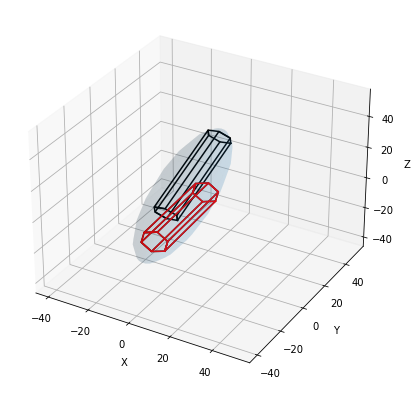

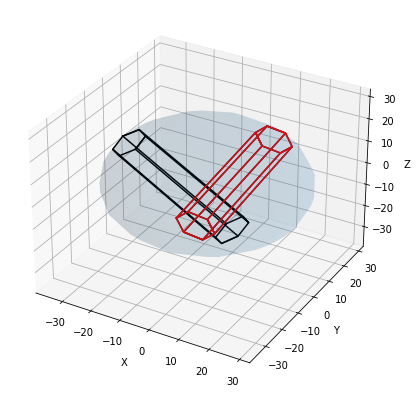

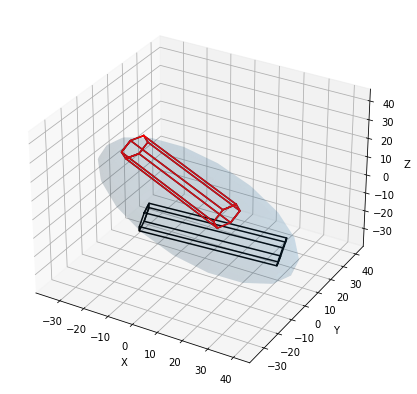

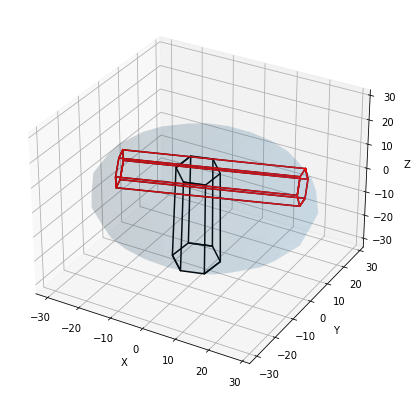

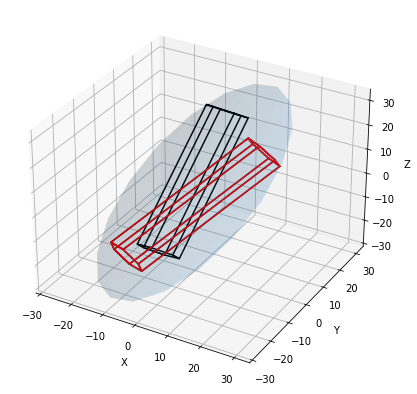

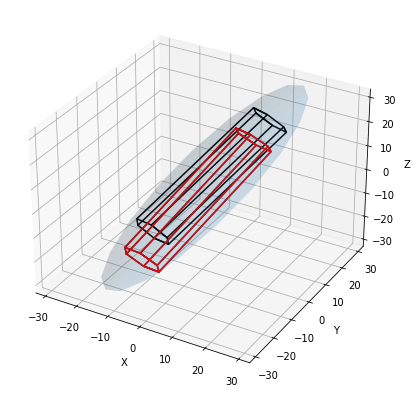

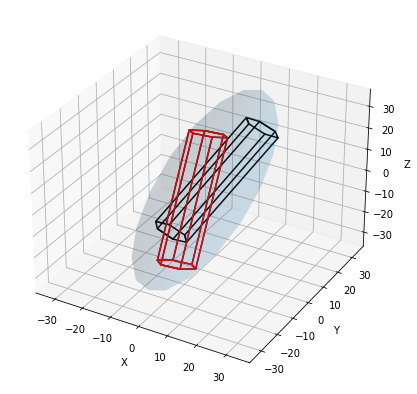

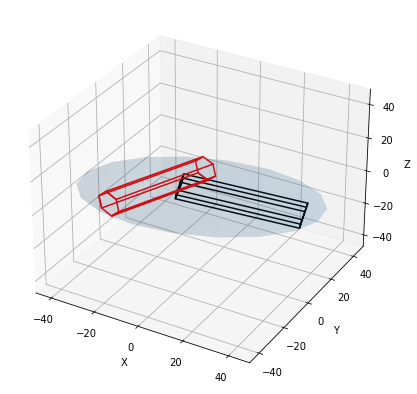

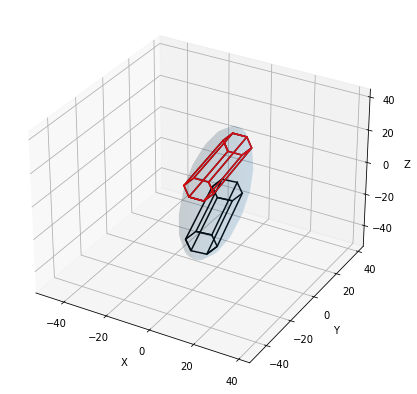

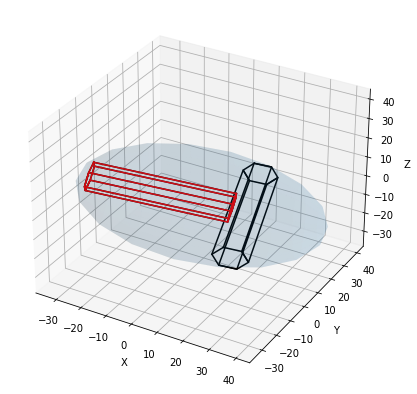

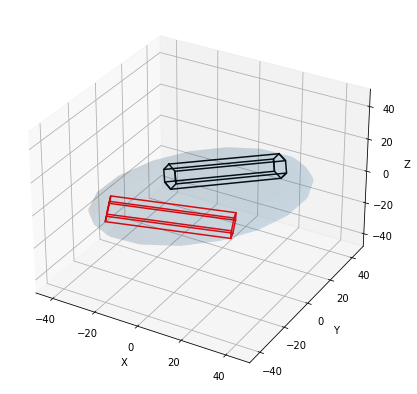

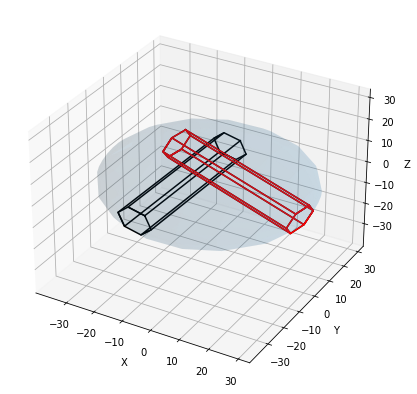

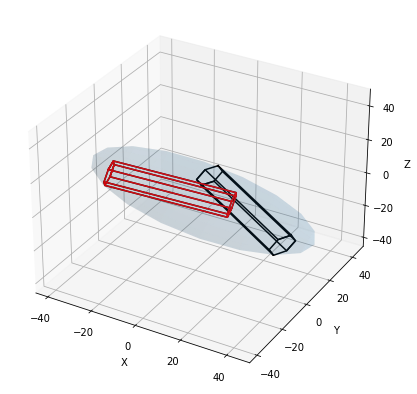

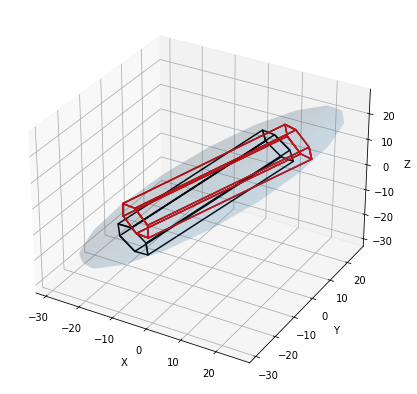

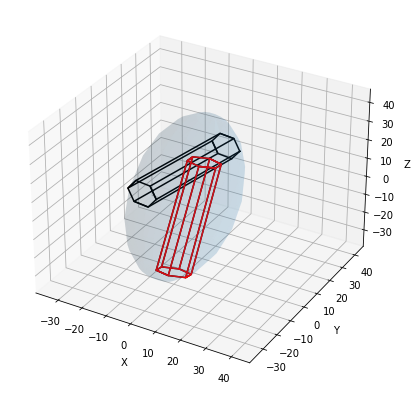

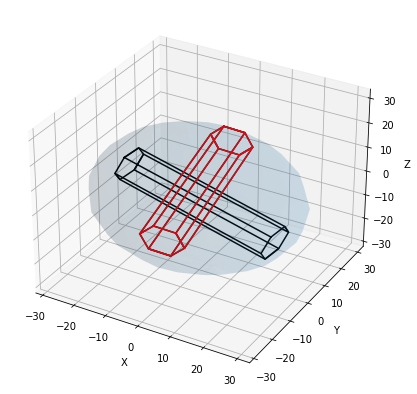

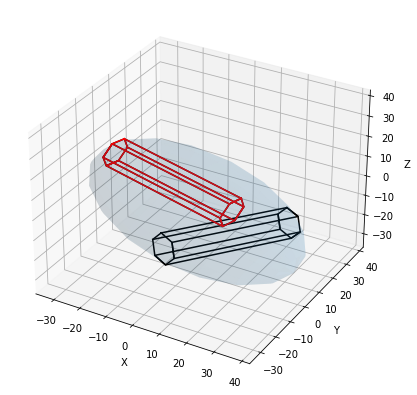

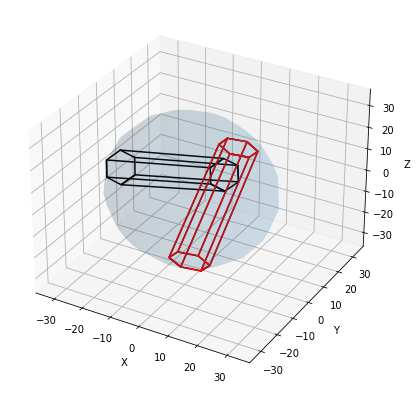

KeyboardInterrupt: 

In [10]:
if __name__ == '__main__':
    # monomer aspect ratios (all the same in agg)
    #phioarr=np.logspace(-2, 2, num=20, dtype=None)#just columns (0,2); plates (-2,0)
    phioarr = [4, 0.25, 0.5, 1.0, 2.0, 4.0, 10.]
    # monomer radii 
    #reqarr = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
    reqarr = [10]
    # how many aggregates to produce
    nclusters = 300
    # number of monomers per aggregate
    ncrystals = 2
    # monomer orientation - random (True) or flat (False)
    rand_orient = False

    output = main()
    agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds = compute()


In [ ]:
#write results to file
with open('../instance_files/instance_iceagg_flat_r10_compareDunnavan_1', "ab") as f:
    pickle.dump((agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds, major_ax_zs, depths), f)
    f.close()